# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [2]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


## ⚙️ Import Libraries

In [3]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

from datetime import datetime
import pandas as pd
from collections import Counter
from scipy.ndimage import label

import cv2

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load the Data

In [4]:
data = np.load("mars_for_students_no_aliens.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

# Separiamo il train set in training e validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42  # 20% per il validation set
)

# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
###
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)

print(f"Training X shape: {X_train.shape}")
print(f"Validation X shape: {X_val.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2004, 64, 128, 1)
Validation X shape: (501, 64, 128, 1)
Training y shape: (2004, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [5]:
category_map = {
  0: 0, #Background
  1: 1, #Soil
  2: 2, #Bedrock
  3: 3, #Sand
  4: 4, #Big Rock
}

In [6]:
def visualize_image_label_pairs(X, y, num_images, class_names, reverse=0):
    """
    Visualize pairs of original images and their corresponding label overlays,
    and add a color legend for the labels.

    Args:
        X: Array of images (shape: [num_samples, height, width, channels]).
        y: Array of labels (shape: [num_samples, height, width]).
        num_images: Number of image-label pairs to visualize.
        class_names: List of class names (optional). If provided, a legend will be added.
    """

    if reverse == 1:
        X = X[::-1]
        y = y[::-1]

    # Set up the grid layout: 2 columns, num_images rows
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

    # Define a custom colormap for the legend
    if class_names is not None:
        cmap = mcolors.ListedColormap(plt.cm.jet(np.linspace(0, 1, len(class_names))))
        norm = mcolors.BoundaryNorm(np.arange(len(class_names)+1), len(class_names))
    else:
        cmap = 'jet'
        norm = None

    for i in range(num_images):
        # Extract the image and its corresponding label
        image = X[i]
        label = y[i]

        # Show the original image in the first column
        ax = axes[i, 0] if num_images > 1 else axes[0]
        ax.imshow(image.squeeze(), cmap='gray')  # Use squeeze for grayscale images
        ax.axis('off')
        ax.set_title(f"Image {i+1}")

        # Show the image with the label overlay in the second column
        ax = axes[i, 1] if num_images > 1 else axes[1]
        ax.imshow(image.squeeze(), cmap='gray')  # Background: original image
        ax.imshow(label, alpha=0.5, cmap=cmap, norm=norm)  # Label overlay
        ax.axis('off')
        ax.set_title(f"Label Overlay {i+1}")

    # Add the legend if class names are provided
    if class_names is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(len(class_names))]
        plt.legend(handles, class_names, title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

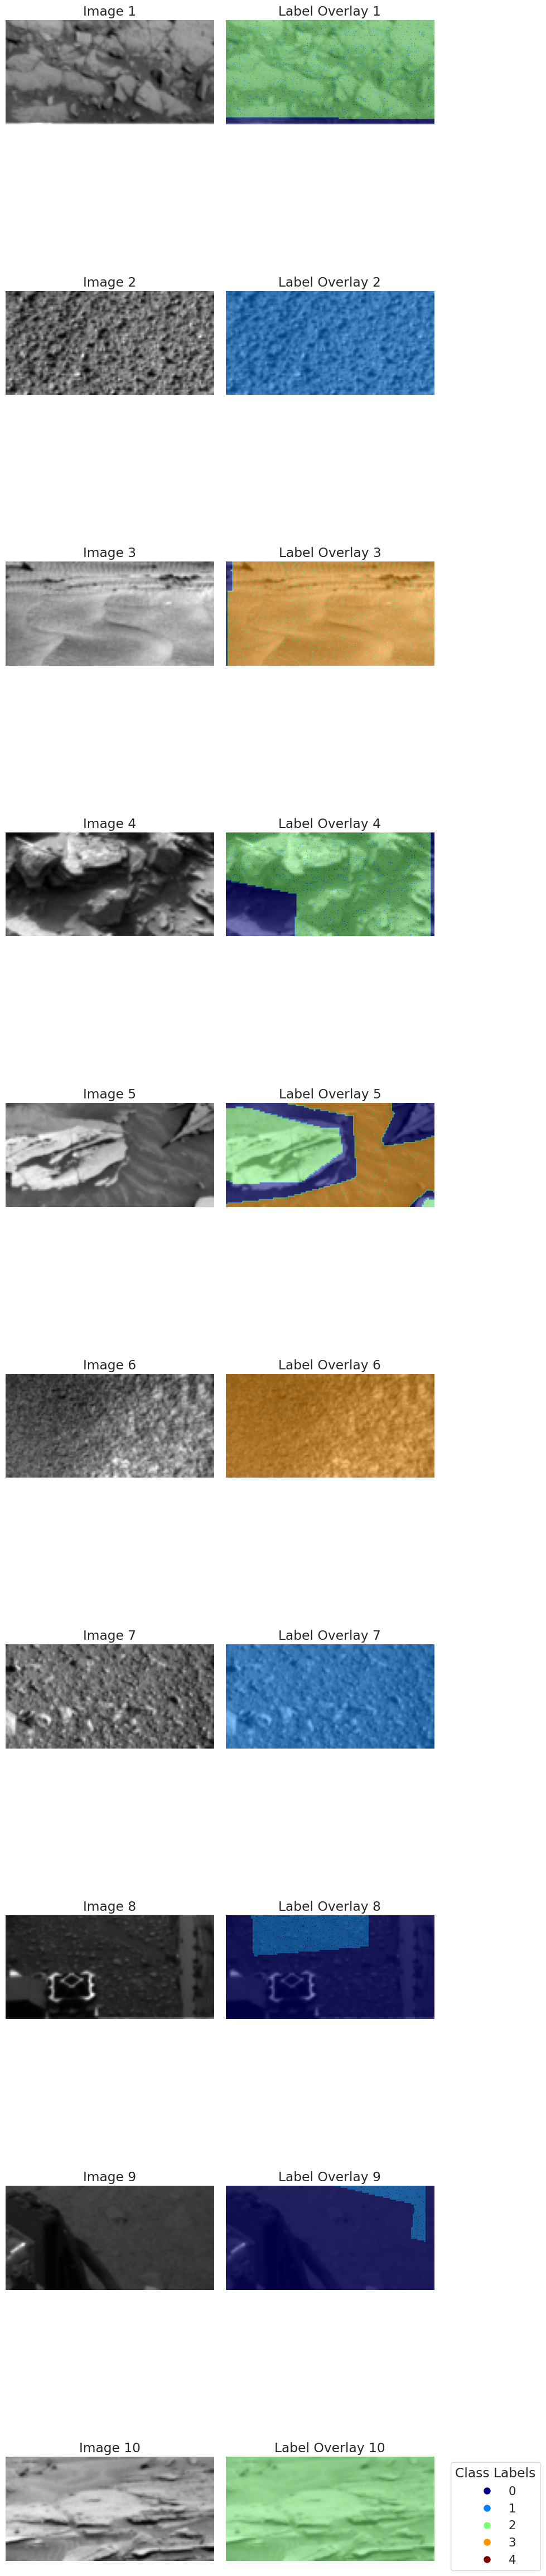

In [7]:
visualize_image_label_pairs(X_train, y_train, num_images=10, class_names=category_map, reverse=1)

##Apply augmentation

In [8]:
from scipy.ndimage import map_coordinates, gaussian_filter

def rotate_image_and_label(image, label, angle):
    """
    Rotate an image and its corresponding label by a given angle.

    Parameters:
    - image: The image to rotate (H, W, C).
    - label: The label (segmentation mask) to rotate (H, W).
    - angle: The angle (in degrees) by which to rotate.

    Returns:
    - rotated_image: Rotated image.
    - rotated_label: Rotated label.
    """
    # Get image dimensions
    h, w = image.shape[:2]
    center = (w // 2, h // 2)

    # Rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Rotate image
    rotated_image = cv2.warpAffine(
        image,
        rotation_matrix,
        (w, h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_REFLECT_101
    )

    # Rotate label (nearest neighbor to preserve integer values)
    rotated_label = cv2.warpAffine(
        label,
        rotation_matrix,
        (w, h),
        flags=cv2.INTER_NEAREST,
        borderMode=cv2.BORDER_REFLECT_101
    )

    return rotated_image, rotated_label

    from scipy.ndimage import map_coordinates, gaussian_filter

def elastic_transform(image, label, alpha, sigma):
    """
    Apply elastic deformation to an image and its label.
    """
    random_state = np.random.RandomState(None)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
    augmented_image = map_coordinates(image, indices, order=1).reshape(shape)
    augmented_label = map_coordinates(label, indices, order=0).reshape(shape)

    return augmented_image, augmented_label


def zoom_image_and_label(image, label, zoom_factor):
    """
    Zoom an image and its corresponding label by a given zoom factor.

    Parameters:
    - image: The image to zoom (H, W, C).
    - label: The label (segmentation mask) to zoom (H, W).
    - zoom_factor: Zoom factor (>1 for zoom in, <1 for zoom out).

    Returns:
    - zoomed_image: Zoomed image.
    - zoomed_label: Zoomed label.
    """
    h, w = image.shape[:2]

    # Calculate the cropping region for zoom
    center_x, center_y = w // 2, h // 2
    new_width, new_height = int(w / zoom_factor), int(h / zoom_factor)
    x1, y1 = max(0, center_x - new_width // 2), max(0, center_y - new_height // 2)
    x2, y2 = x1 + new_width, y1 + new_height

    # Crop and resize the image
    zoomed_image = cv2.resize(image[y1:y2, x1:x2], (w, h), interpolation=cv2.INTER_LINEAR)

    # Crop and resize the label
    zoomed_label = cv2.resize(label[y1:y2, x1:x2], (w, h), interpolation=cv2.INTER_NEAREST)

    return zoomed_image, zoomed_label

def blur_image(image, kernel_size=(5, 5)):
    """
    Apply Gaussian blur to an image.

    Parameters:
    - image: The image to blur (H, W, C).
    - kernel_size: Size of the Gaussian kernel.

    Returns:
    - blurred_image: Blurred image.
    """
    blurred_image = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred_image

def augment_data_extended(X, y, num_augmentations=1):
    """
    Perform data augmentation on the dataset (rotation, flipping, zoom, and blurring).

    Parameters:
    - X: array of images (num_samples, height, width, channels).
    - y: array of labels (segmentation masks) (num_samples, height, width).
    - num_augmentations: Number of augmentations to generate for each image.

    Returns:
    - augmented_X: Augmented images.
    - augmented_y: Corresponding labels.
    """
    augmented_X, augmented_y = [], []

    for i in range(len(X)):
        image = X[i]
        label = y[i]

        for _ in range(num_augmentations):
            augmented_image, augmented_label = image.copy(), label.copy()

            # Random rotation
            if np.random.rand() > 0.5:
                angle = np.random.uniform(-45, 45)  # Random angle between -45 and 45 degrees
                augmented_image, augmented_label = rotate_image_and_label(augmented_image[..., 0], augmented_label, angle)
                augmented_image = augmented_image[..., np.newaxis]  # Restore channel dimension

            # Random flip
            if np.random.rand() > 0.5:
                augmented_image = np.fliplr(augmented_image)
                augmented_label = np.fliplr(augmented_label)

            if np.random.rand() > 0.5:
                augmented_image = np.flipud(augmented_image)
                augmented_label = np.flipud(augmented_label)

            # Random zoom
            if np.random.rand() > 0.5:
                zoom_factor = np.random.uniform(0.8, 1.2)  # Zoom between 80% and 120%
                augmented_image, augmented_label = zoom_image_and_label(augmented_image[..., 0], augmented_label, zoom_factor)
                augmented_image = augmented_image[..., np.newaxis]  # Restore channel dimension

             # Random elastic
            if np.random.rand() > 0.5:
                alpha = 15  # Intensity of deformation
                sigma = 4   # Gaussian filter size
                augmented_image, augmented_label = elastic_transform(augmented_image[..., 0], augmented_label, alpha, sigma)
                augmented_image = augmented_image[..., np.newaxis]  # Restore channel dimension


            # Random blur (apply only to the image, not the label)
            if np.random.rand() > 0.5:
                augmented_image = blur_image(augmented_image[..., 0])
                augmented_image = augmented_image[..., np.newaxis]  # Restore channel dimension

            augmented_X.append(augmented_image)
            augmented_y.append(augmented_label)

    return np.array(augmented_X), np.array(augmented_y)


In [9]:
# Aumenta il numero di augmentazioni per immagine
X_aug, y_aug = augment_data_extended(X_train, y_train, num_augmentations=2)

# Combina i dati originali con quelli augmentati
X_train_augmented = np.concatenate((X_train, X_aug), axis=0)
y_train_augmented = np.concatenate((y_train, y_aug), axis=0)
# Stampa il numero totale di immagini
print(f"Original training set size: {X_train.shape[0]}")
print(f"Augmented training set size: {X_train_augmented.shape[0]}")

print(f"Original labels size: {y_train.shape}")
print(f"Augmented labels size: {y_train_augmented.shape}")

X_train = X_train_augmented
y_train = y_train_augmented

Original training set size: 2004
Augmented training set size: 6012
Original labels size: (2004, 64, 128)
Augmented labels size: (6012, 64, 128)


Visualizing examples from the training set:


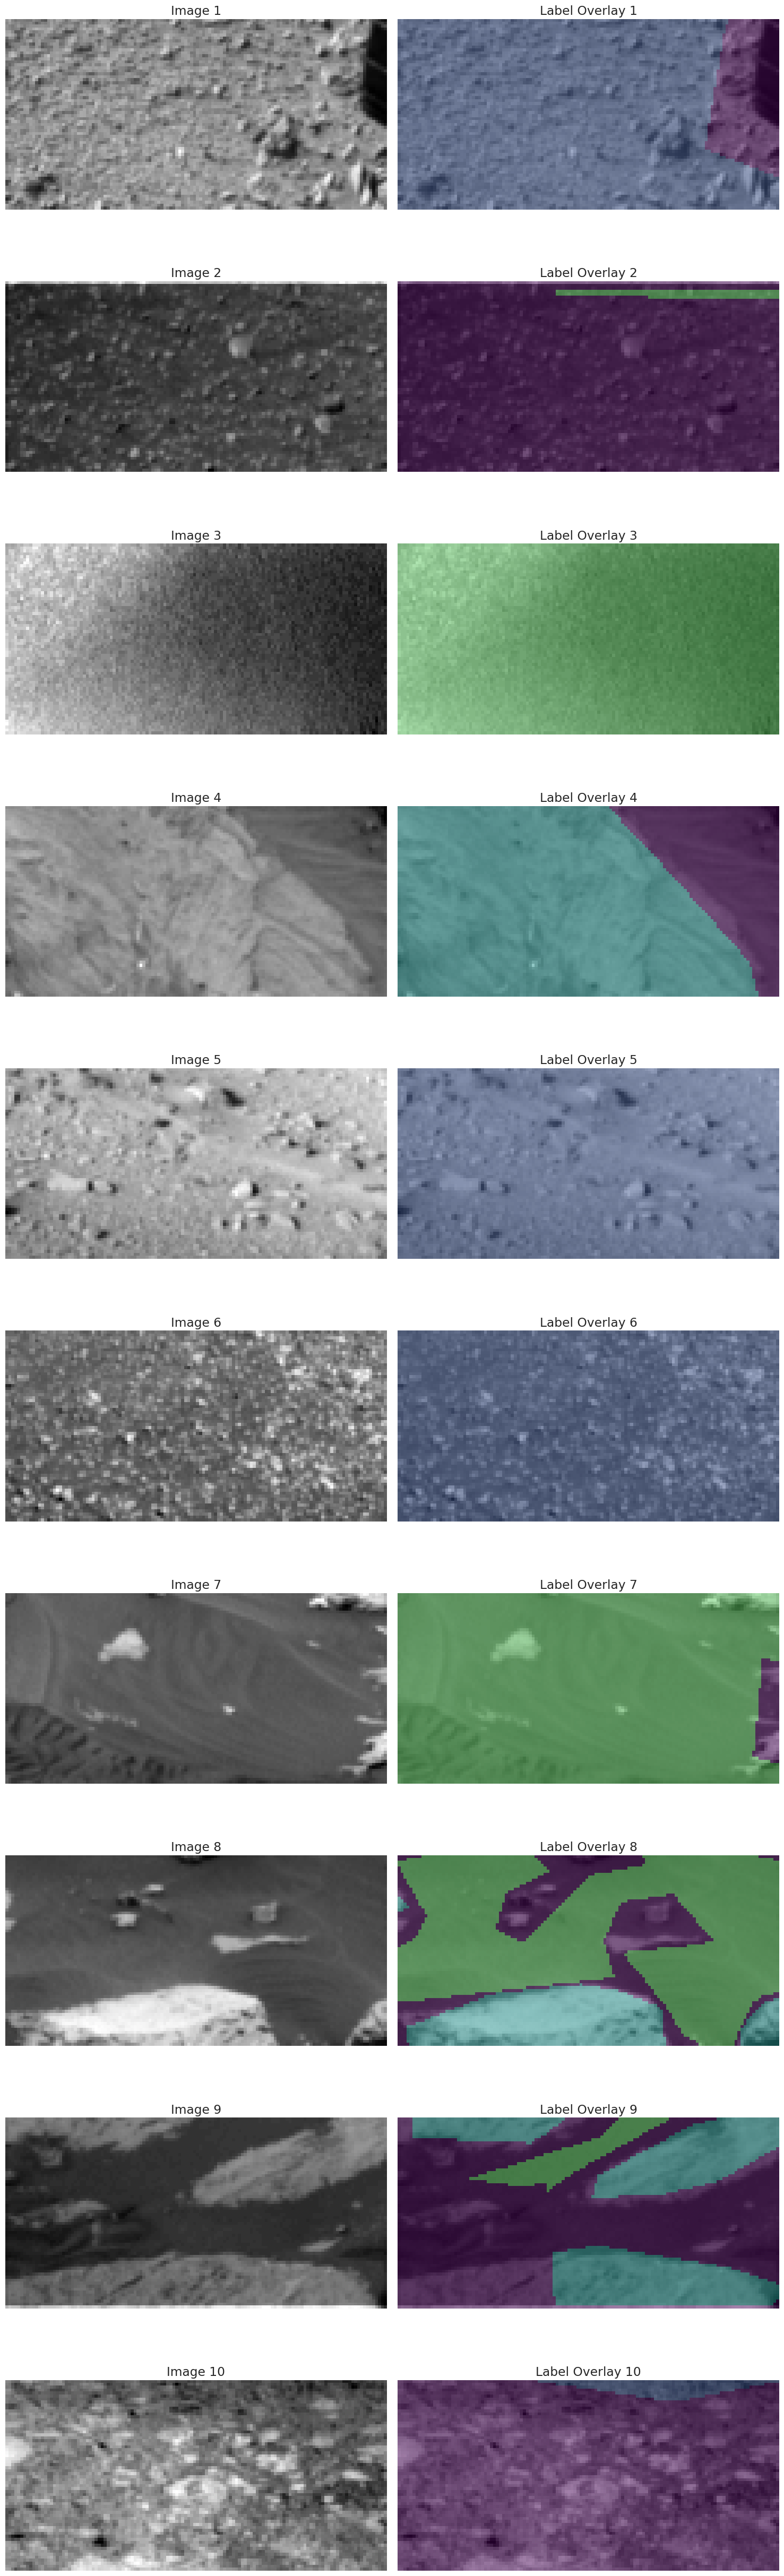

In [10]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(x, y, num_samples=3, class_names=None):
    """
    Display some image and label pairs with label overlays.
    Parameters:
    - x: Array of images.
    - y: Array of labels.
    - num_samples: Number of samples to display.
    - class_names: List of class names for the legend.
    """
    plt.figure(figsize=(15, 5 * num_samples))

    num_classes = len(np.unique(y))
    colormap = create_segmentation_colormap(num_classes)

    for j in range(min(num_samples, len(x))):
        # Plot original image
        plt.subplot(num_samples, 2, j * 2 + 1)
        plt.imshow(x[j].squeeze(), cmap='gray')  # Display grayscale image
        plt.title(f'Image {j+1}')
        plt.axis('off')

        # Plot image with label overlay
        plt.subplot(num_samples, 2, j * 2 + 2)
        plt.imshow(x[j].squeeze(), cmap='gray')  # Display grayscale image as background
        colored_label = apply_colormap(y[j], colormap)
        plt.imshow(colored_label, alpha=0.5)  # Overlay label with transparency
        plt.title(f'Label Overlay {j+1}')
        plt.axis('off')

    # Add legend if class names are provided
    if class_names is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap[i], markersize=10)
                   for i in range(len(class_names))]
        plt.legend(handles, class_names, title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    plt.close()

# Example usage
print("Visualizing examples from the training set:")
plot_sample_batch(X_train, y_train, num_samples=10)

##Build model

In [11]:
num_classes = len(np.unique(y_train))
input_shape = (64, 128, 1)

In [12]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model

def unet_plus_plus_with_feature_fusion(input_shape=(64, 128, 1), num_classes=5, l2_factor=0.001, dropout_rate=0.3):
    inputs = tfkl.Input(input_shape)

    # Encoder
    conv1 = tfkl.Conv2D(64, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(inputs)
    conv1 = tfkl.BatchNormalization()(conv1)
    conv1 = tfkl.Conv2D(64, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(conv1)
    conv1 = tfkl.BatchNormalization()(conv1)
    conv1 = tfkl.Dropout(dropout_rate)(conv1)
    pool1 = tfkl.MaxPooling2D((2, 2))(conv1)

    conv2 = tfkl.Conv2D(128, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(pool1)
    conv2 = tfkl.BatchNormalization()(conv2)
    conv2 = tfkl.Conv2D(128, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(conv2)
    conv2 = tfkl.BatchNormalization()(conv2)
    conv2 = tfkl.Dropout(dropout_rate)(conv2)
    pool2 = tfkl.MaxPooling2D((2, 2))(conv2)

    conv3 = tfkl.Conv2D(256, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(pool2)
    conv3 = tfkl.BatchNormalization()(conv3)
    conv3 = tfkl.Conv2D(256, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(conv3)
    conv3 = tfkl.BatchNormalization()(conv3)
    conv3 = tfkl.Dropout(dropout_rate)(conv3)
    pool3 = tfkl.MaxPooling2D((2, 2))(conv3)

    conv4 = tfkl.Conv2D(512, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(pool3)
    conv4 = tfkl.BatchNormalization()(conv4)
    conv4 = tfkl.Conv2D(512, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(conv4)
    conv4 = tfkl.BatchNormalization()(conv4)
    conv4 = tfkl.Dropout(dropout_rate)(conv4)
    pool4 = tfkl.MaxPooling2D((2, 2))(conv4)

    # Bottleneck
    bottleneck = tfkl.Conv2D(1024, (3, 3), padding='same', activation='relu',
                              kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(pool4)
    bottleneck = tfkl.BatchNormalization()(bottleneck)
    bottleneck = tfkl.Conv2D(1024, (3, 3), padding='same', activation='relu',
                              kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(bottleneck)
    bottleneck = tfkl.BatchNormalization()(bottleneck)
    bottleneck = tfkl.Dropout(dropout_rate)(bottleneck)

    # Decoder with Multi-level Feature Fusion
    up3 = tfkl.UpSampling2D((2, 2))(bottleneck)
    conv4_aligned = tfkl.Conv2D(512, (1, 1), padding='same')(conv4)  # Align channels
    up3 = tfkl.Concatenate()([up3, conv4_aligned])
    conv5 = tfkl.Conv2D(512, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(up3)
    conv5 = tfkl.BatchNormalization()(conv5)
    conv5 = tfkl.Conv2D(512, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(conv5)
    conv5 = tfkl.BatchNormalization()(conv5)
    conv5 = tfkl.Dropout(dropout_rate)(conv5)

    up2 = tfkl.UpSampling2D((2, 2))(conv5)
    conv3_aligned = tfkl.Conv2D(256, (1, 1), padding='same')(conv3)  # Align channels
    up2 = tfkl.Concatenate()([up2, conv3_aligned])
    conv6 = tfkl.Conv2D(256, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(up2)
    conv6 = tfkl.BatchNormalization()(conv6)
    conv6 = tfkl.Conv2D(256, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(conv6)
    conv6 = tfkl.BatchNormalization()(conv6)
    conv6 = tfkl.Dropout(dropout_rate)(conv6)

    up1 = tfkl.UpSampling2D((2, 2))(conv6)
    conv2_aligned = tfkl.Conv2D(128, (1, 1), padding='same')(conv2)  # Align channels
    up1 = tfkl.Concatenate()([up1, conv2_aligned])
    conv7 = tfkl.Conv2D(128, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(up1)
    conv7 = tfkl.BatchNormalization()(conv7)
    conv7 = tfkl.Conv2D(128, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(conv7)
    conv7 = tfkl.BatchNormalization()(conv7)
    conv7 = tfkl.Dropout(dropout_rate)(conv7)

    up0 = tfkl.UpSampling2D((2, 2))(conv7)
    conv1_aligned = tfkl.Conv2D(64, (1, 1), padding='same')(conv1)  # Align channels
    up0 = tfkl.Concatenate()([up0, conv1_aligned])
    conv8 = tfkl.Conv2D(64, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(up0)
    conv8 = tfkl.BatchNormalization()(conv8)
    conv8 = tfkl.Conv2D(64, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(conv8)
    conv8 = tfkl.BatchNormalization()(conv8)
    conv8 = tfkl.Dropout(dropout_rate)(conv8)

    # Output layer for 5 classes
    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.L2(l2_factor))(conv8)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = unet_plus_plus_with_feature_fusion(input_shape=input_shape, num_classes=num_classes)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 128, 64)    │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 128, 64)    │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 128, 64)    │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 128, 64)    │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 128, 64)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 64, 64)     │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 64, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 32, 128)    │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 16, 32, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 32, 256)    │        590,080 │ batch_normalization_4… │
├──────────────────────

 Total params: 31,750,725 (121.12 MB)

 Trainable params: 31,738,949 (121.07 MB)

 Non-trainable params: 11,776 (46.00 KB)

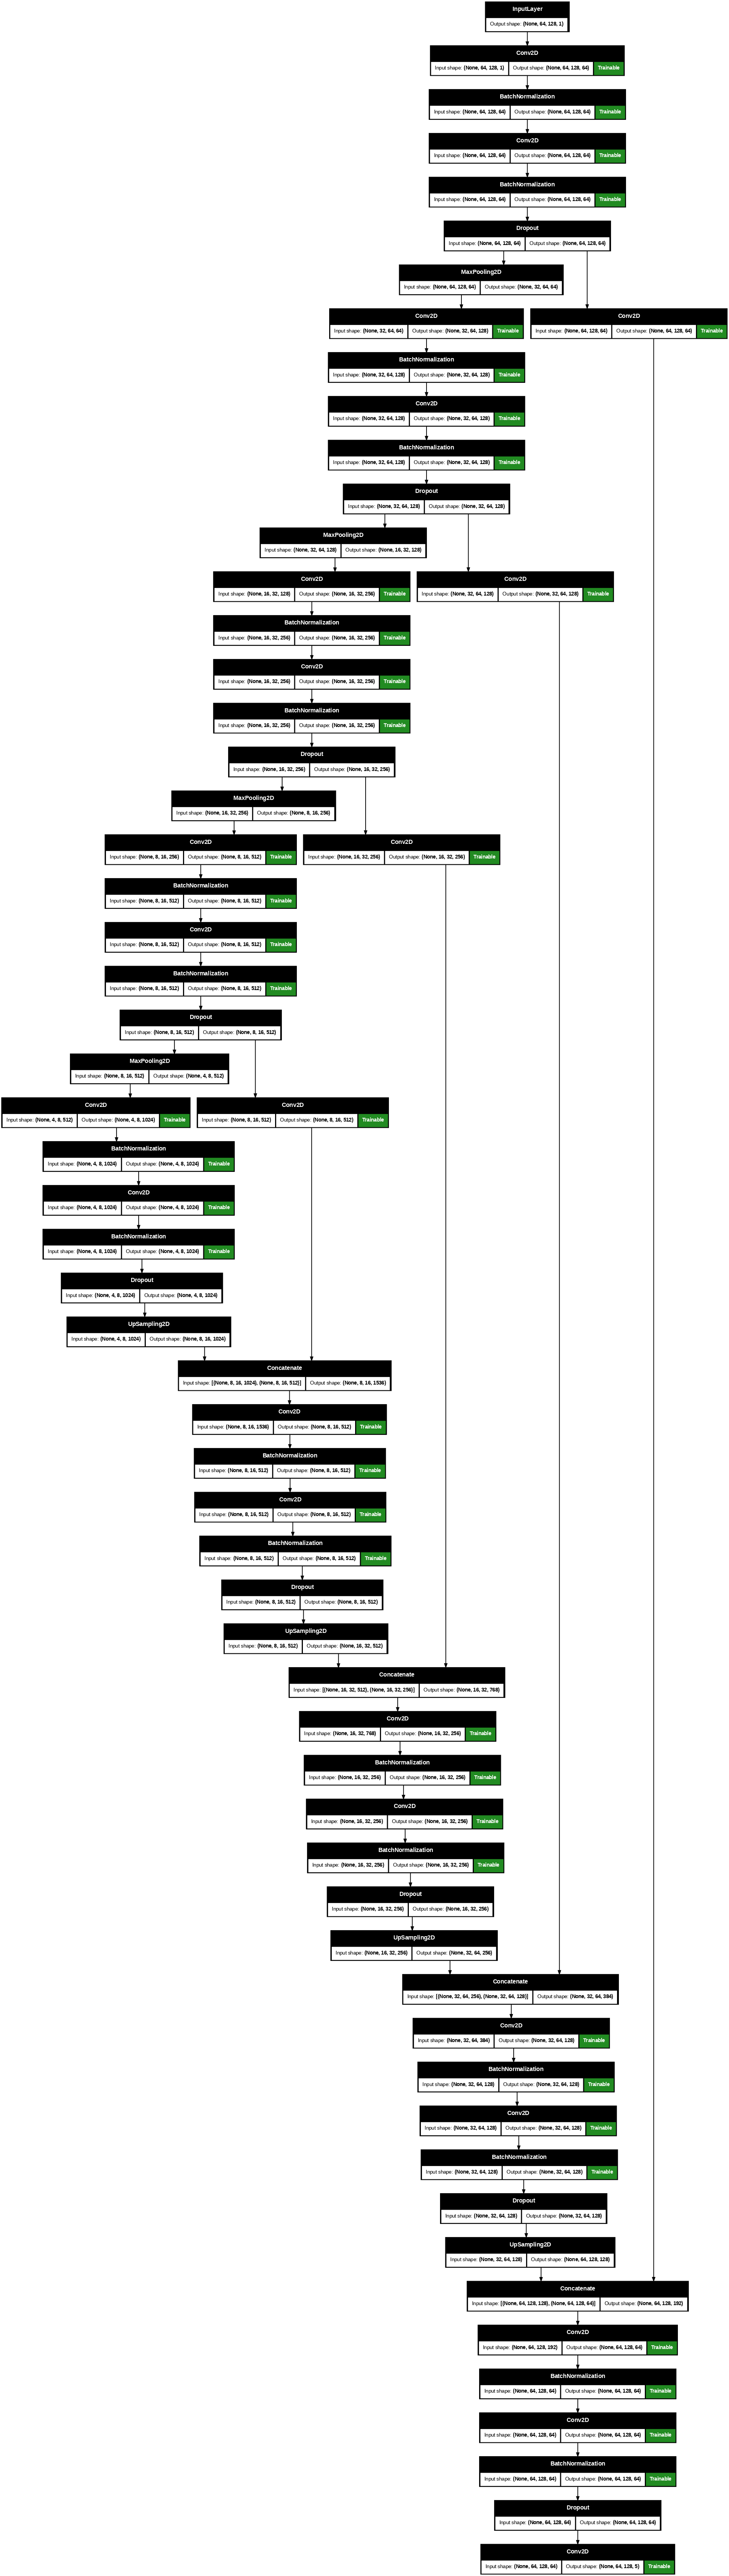

In [13]:
# Compiling the model
model.summary()

# Visualize the model and save the image
tfk.utils.plot_model(model, show_trainable=True, show_shapes=True, dpi=70)

## 🛠️ Train and Save the Model

[0.0, 0.18731711641645757, 0.22611143278525958, 0.2511108809155231, 0.33546056988275963]


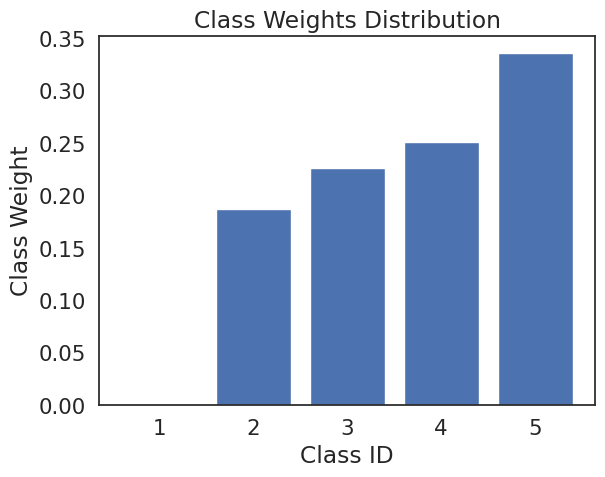

In [14]:
# Funzione per calcolare i pesi delle classi come percentuali
def calculate_class_weights(X_train, y_train, exponent=2):
    class_counts = Counter()  # Contatore per il numero di occorrenze per ciascuna classe
    total_pixels = 0  # Numero totale di pixel in tutto il dataset

    # Itera su ogni immagine nel dataset
    for i in range(X_train.shape[0]):
        mask = y_train[i]  # Ottieni la maschera di classe per l'immagine
        unique_classes = np.unique(mask)  # Trova tutte le classi uniche (eccetto la classe di background, 0)

        # Per ogni classe presente nell'immagine
        for class_id in unique_classes:
            if class_id == 0:  # Ignora la classe di background (0)
                continue
            # Conta il numero di pixel per classe
            class_counts[class_id] += np.sum(mask == class_id)
            total_pixels += mask.size  # Aggiungi il numero di pixel di questa immagine

    # Creare un dizionario dei pesi per ciascuna classe
    class_weights = []

    # Calcolare il peso delle classi come inversamente proporzionale al numero di occorrenze
    for class_id in range(1, max(class_counts.keys()) + 1):  # Itera su tutte le classi (ignorando lo sfondo)
        class_pixel_count = class_counts.get(class_id, 1)  # Default a 1 se la classe non è presente
        # Calcolare il peso come inversamente proporzionale alla frequenza della classe
        class_weight = (1 - (class_pixel_count / total_pixels)) ** exponent
        class_weights.append(class_weight)

    # Normalizzare i pesi in modo che sommino a 1
    weight_sum = sum(class_weights)
    class_weights = [weight / weight_sum for weight in class_weights]
    class_weights.insert(0, 0.0)

    return class_weights

# Esempio di utilizzo:
# X_train = np.array([...])  # Immagini in bianco e nero (N, H, W)
# y_train = np.array([...])  # Etichette dei pixel (N, H, W)
class_weights = calculate_class_weights(X_train, y_train, exponent=2)

# Stampa i pesi delle classi in formato array (0: peso, 1: peso, ...)
print(class_weights)

# Grafico per visualizzare la distribuzione dei pesi
plt.bar(range(1, len(class_weights) + 1), class_weights)
plt.xlabel('Class ID')
plt.ylabel('Class Weight')
plt.title('Class Weights Distribution')
plt.show()

In [15]:
# Funzione di loss pesata
def weighted_loss(class_weights):
    def loss(y_true, y_pred):
        # Converti class_weights in un tensore
        weights = tf.constant(class_weights, dtype=tf.float32)

        # Assicurati che y_true sia un intero
        y_true = tf.cast(y_true, dtype=tf.int32)

        # Calcola la perdita base (senza pesi)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

        # Calcola i pesi per ogni classe (moltiplicando per il valore corrispondente)
        pixel_weights = tf.gather(weights, y_true)

        # Applica i pesi alla perdita
        weighted_loss = loss * pixel_weights

        # Restituisci la perdita media
        return tf.reduce_mean(weighted_loss)

    return loss

In [16]:
# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

loss_function = weighted_loss(class_weights)

# Compile the model
print("Compiling model...")
model.compile(
    loss=loss_function,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    metrics=["accuracy", mean_iou]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [17]:
# Define Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(factor=0.5, patience=10, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_mean_io_u")
]

In [18]:
# Train the model with early stopping and learning rate scheduler
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 79s 220ms/step - accuracy: 0.2998 - loss: 2.6423 - mean_io_u: 0.1433 - val_accuracy: 0.3473 - val_loss: 0.3573 - val_mean_io_u: 0.1151 - learning_rate: 0.0100
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.3317 - loss: 0.3746 - mean_io_u: 0.1619 - val_accuracy: 0.3473 - val_loss: 0.4448 - val_mean_io_u: 0.1151 - learning_rate: 0.0100
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.3771 - loss: 0.3335 - mean_io_u: 0.2003 - val_accuracy: 0.3629 - val_loss: 0.3141 - val_mean_io_u: 0.1489 - learning_rate: 0.0100
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.4036 - loss: 0.2889 - mean_io_u: 0.2762 - val_accuracy: 0.3485 - val_loss: 0.3127 - val_mean_io_u: 0.1174 - learning_rate: 0.0100
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.4156 - loss: 0.2825 - mean_io_u: 0.2528 - val_accuracy: 0.3628 - val_loss: 0.2916 - val_mean_io_u: 0.1424 - learning_rate: 0.0100
Epoch 6/

# POSTPROCESSING

In [19]:
import numpy as np
import tensorflow as tf
from scipy.ndimage import gaussian_filter

# Apply CRF Function
def apply_crf(image, prob_map, num_classes=5, iterations=5, spatial_weight=10, bilateral_weight=80):
    h, w, c = image.shape
    refined_prob_map = np.copy(prob_map)

    # Normalize the probability map
    refined_prob_map = refined_prob_map / refined_prob_map.sum(axis=-1, keepdims=True)

    for _ in range(iterations):
        # Spatial smoothness
        spatial_smooth = np.zeros_like(refined_prob_map)
        for i in range(num_classes):
            spatial_smooth[..., i] = gaussian_filter(refined_prob_map[..., i], sigma=spatial_weight)

        # Bilateral smoothness
        bilateral_smooth = np.zeros_like(refined_prob_map)
        for i in range(num_classes):
            bilateral_smooth[..., i] = gaussian_filter(refined_prob_map[..., i] * image[..., 0], sigma=bilateral_weight)

        # Combine terms with the original probability map
        refined_prob_map = prob_map + spatial_smooth + bilateral_smooth

        # Normalize probabilities
        refined_prob_map = refined_prob_map / refined_prob_map.sum(axis=-1, keepdims=True)

    # Convert probability map to labels
    segmentation_map = np.argmax(refined_prob_map, axis=-1)

    return segmentation_map

# Load your dataset
data = np.load("mars_for_students_no_aliens.npz")
X_test = data["test_set"]

# Ensure input image format matches CRF input (H, W, C)
X_test = X_test[..., np.newaxis] / 255.0  # Add channel and normalize

# Make predictions with your trained model
y_pred = model.predict(X_test)  # Shape: (num_samples, H, W, num_classes)

# Postprocess each sample
postprocessed_masks = []
for i in range(len(X_test)):
    image = X_test[i]  # Shape: (H, W, C)
    prob_map = y_pred[i]  # Shape: (H, W, num_classes)
    postprocessed_mask = apply_crf(image, prob_map, num_classes=5)
    postprocessed_masks.append(postprocessed_mask)

postprocessed_masks = np.array(postprocessed_masks)  # Shape: (num_samples, H, W)

314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step


In [21]:
y_pred = model.predict(X_test)  # Shape: (num_samples, H, W, num_classes)
y_test_pseudo = np.argmax(y_pred, axis=-1)  # Convert probabilities to labels


314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [22]:
print(f"Shape of y_val: {y_test_pseudo.shape}")
print(f"Shape of postprocessed_masks: {postprocessed_masks.shape}")


Shape of y_val: (10022, 64, 128)
Shape of postprocessed_masks: (10022, 64, 128)


In [23]:
# Evaluate the Postprocessed Results
mean_iou = tf.keras.metrics.MeanIoU(num_classes=5)
mean_iou.update_state(y_test_pseudo, postprocessed_masks)
print("Mean IoU after CRF Postprocessing:", mean_iou.result().numpy())

Mean IoU after CRF Postprocessing: 0.7927642


In [24]:
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_val: {y_val.shape}")


Shape of X_test: (10022, 64, 128, 1)
Shape of y_val: (501, 64, 128)


In [25]:
# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model20.keras'
model.save(model_filename)

##Results

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


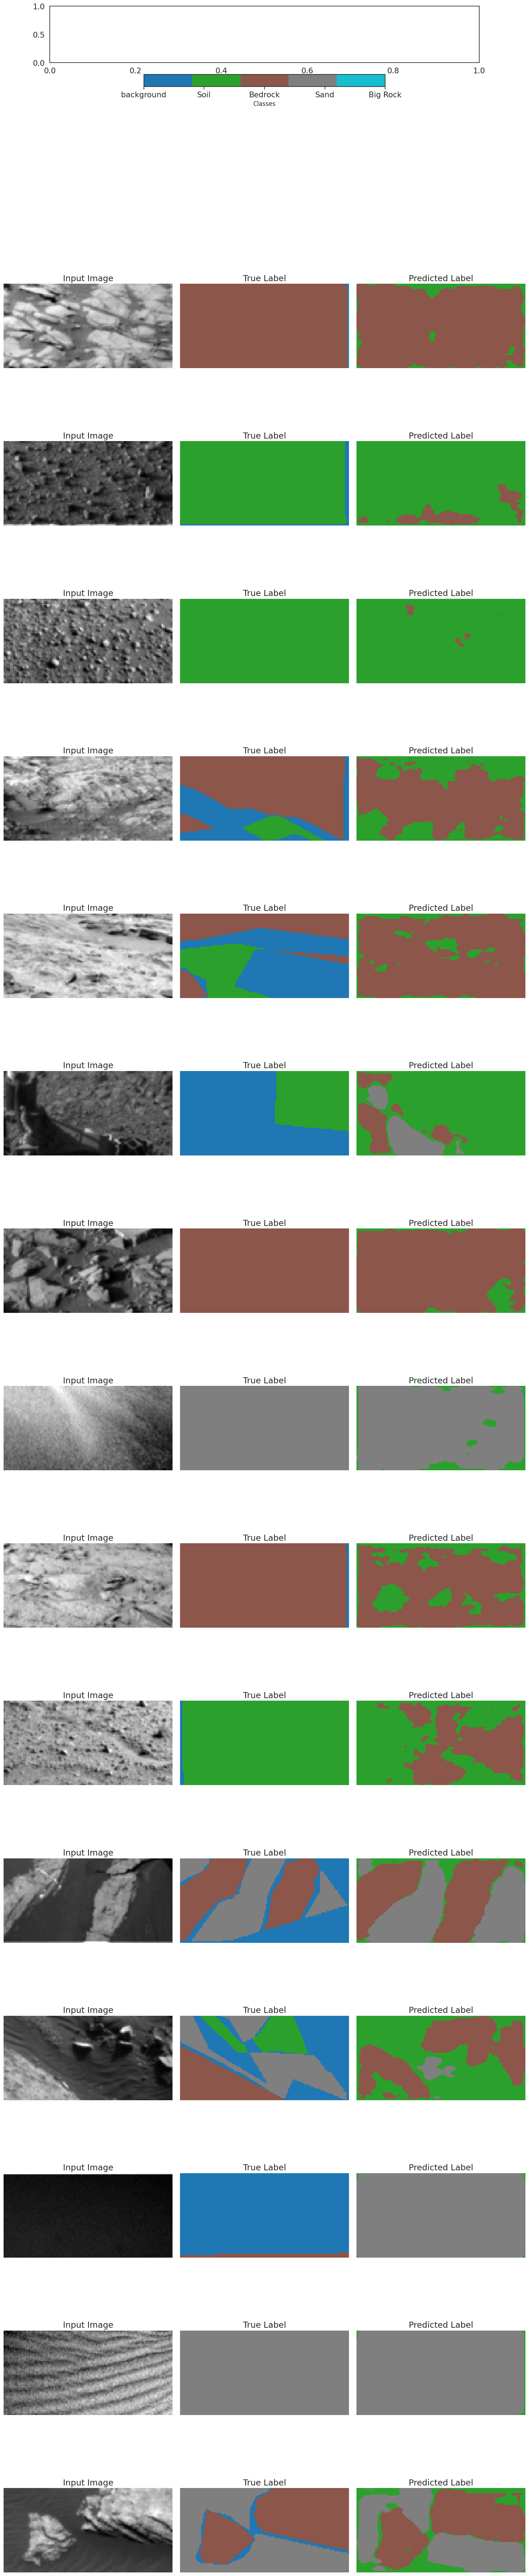

In [27]:
# Make predictions on the validation set
predictions = model.predict(X_val)
predicted_classes = np.argmax(predictions, axis=-1)

# Function to visualize predictions with class legend at the top
def visualize_predictions_with_legend(X, y_true, y_pred, class_names, num_examples=5):
    """
    Visualize predictions vs true labels for the validation set with a legend at the top.
    Args:
        X: Input images (validation set).
        y_true: True labels.
        y_pred: Predicted labels.
        class_names: List of class names corresponding to the labels.
        num_examples: Number of examples to visualize.
    """
    # Define the colormap
    num_classes = len(class_names)
    cmap = plt.cm.get_cmap('tab10', num_classes)

    # Create the figure
    plt.figure(figsize=(15, num_examples * 5))

    # Add the legend as a standalone colorbar at the top
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_classes - 1)),
        ax=plt.gcf().add_axes([0.1, 0.95, 0.8, 0.03]),  # Position of the colorbar (top of the figure)
        orientation='horizontal'
    )
    cbar.set_ticks(range(num_classes))
    cbar.set_ticklabels(class_names)
    cbar.set_label("Classes", fontsize=12)

    # Visualize each example
    for i in range(num_examples):
        # Input image
        plt.subplot(num_examples, 3, i * 3 + 1)
        plt.imshow(X[i, :, :, 0], cmap='gray')  # Show the grayscale input
        plt.title("Input Image")
        plt.axis('off')

        # True label
        plt.subplot(num_examples, 3, i * 3 + 2)
        plt.imshow(y_true[i], cmap=cmap, vmin=0, vmax=num_classes - 1)  # Show true labels
        plt.title("True Label")
        plt.axis('off')

        # Predicted label
        plt.subplot(num_examples, 3, i * 3 + 3)
        plt.imshow(y_pred[i], cmap=cmap, vmin=0, vmax=num_classes - 1)  # Show predicted labels
        plt.title("Predicted Label")
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave space at the top for the colorbar
    plt.show()

# Define the class names
class_names = ["background","Soil","Bedrock","Sand", "Big Rock"]

# Visualize predictions on the first few examples
visualize_predictions_with_legend(X_val, y_val, predicted_classes, class_names, num_examples=15)

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [28]:
tfk.config.enable_unsafe_deserialization()
model = tfk.models.load_model('model20.keras', compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model20.keras


In [29]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Predictions shape: (10022, 64, 128)


In [30]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [31]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>